In [59]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
from scipy.stats import poisson
from datetime import datetime
warnings.filterwarnings('ignore')


In [108]:
# load dnds
lineage_dnds_expect = pd.read_csv('../../donor_species/final_SNP/withcom/pre/allexpectNSratio.txt',sep='\t')
lineage_dnds_expect = lineage_dnds_expect.loc[:,['#donor_species', 'A-T_N:S',
       'A-C_N:S',  'G-C_N:S', 'G-T_N:S',
       'A-G_N:S',  'G-A_N:S']]
lineage_dnds_expect = lineage_dnds_expect[~lineage_dnds_expect['A-G_N:S'].isna()]
lineage_dnds_expect = lineage_dnds_expect[lineage_dnds_expect['A-G_N:S']!='0:0']
lineage_dnds_expect.head()


,#donor_species,A-T_N:S,A-C_N:S,G-C_N:S,G-T_N:S,A-G_N:S,G-A_N:S
0,AkMu_clustercluster1.donor.am,943599:129665,951308:121956,1055280:315424,1021372:349332,793823:279441,817639:553065
1,AkSp_clustercluster1.donor.aa,1051541:131511,1057465:125587,1202052:365110,1162193:404969,897099:285953,916743:650419
2,AlOn_clustercluster2.donor.am,1326979:131695,1330397:128277,1579361:488486,1510591:557256,1172527:286147,1166513:901334
3,BA_clustercluster1.donor.bk,696788:79214,700454:75548,896895:277934,863837:310992,615051:160951,676367:498462
4,BA_clustercluster10.donor.D25,731045:82183,734258:78970,946401:293961,911573:328789,646728:166500,713533:526829


In [126]:
# remove recombination and low depth
allfiles = glob.glob('../../donor_species/final_SNP/withcom/pre/*vcf')
alldnds = ['lineage\ttotalN\ttotalS\tdnds\texpected\n']
allspecies_dnds = dict()
allspecies_dnds_nopatients = dict()
all_recom_sum = {
    'species':[],
'lineage':[],
    'total No. SNPs':[],
    'total genome length':[],
    'total recombination SNPs':[],
    'total recombination length':[],
    'recombination length cutoff':[]
}

%matplotlib agg 
%matplotlib agg

check_wired_trees = True
plot_file = True
sum_dnds = True
sum_dnds_outputfile = True
plot_contig = False
contig_end_cutoff = 100 # remove SNPs at the end of a contig
min_avg_depth = 6 # for each genome and for each SNP
min_good_alleles = 0.6 # at least 60% genomes have good coverage
quality_alignment_cutoff = 100
recombination_max_FP = 5 # max 5 FP SNPs
recombination_distance_pcutoff = 0.05 #CI 5%
recombination_distance_min = 10000 # distance = 5kbp -> compute cutoff for distance 95% poisson distribution
recombination_distance_max = 0.1e6 #10% genome length -> for lineages with a few SNPs
recombination_total_SNPs = 5 # at most X SNPs caused by recombination,5% * No.SNPs < X
recombination_SNPs = 3 # at least 3 SNPs in a row
max_SNPs = 50 # cluster SNPs if total SNPs >=  max_SNPs

def cat_CHR_POS(allSNPscov):
                allSNPscov['POS_continuous'] = 0
                allSNPscov['CHR_len']=[int(x.split('_')[3]) for x in allSNPscov['CHR']]
                CHR_old = allSNPscov.loc[0,'CHR']
                length_cat = 0
                length_cat_set = []
                CHR_length = {'CHR':[CHR_old],'POS_continuous':[0]}
                for i in range(1,allSNPscov.shape[0]):
                    if allSNPscov.loc[i,'CHR'] != CHR_old:
                        # a new CHR
                        length_cat +=  allSNPscov.loc[i - 1,'CHR_len']
                        length_cat_set.append(length_cat)
                        allSNPscov.loc[i,'POS_continuous'] += length_cat
                        CHR_old = allSNPscov.loc[i,'CHR']
                        CHR_length['CHR'].append(CHR_old)
                        CHR_length['POS_continuous'].append(length_cat)
                    elif allSNPscov.loc[i,'CHR'] != allSNPscov.loc[0,'CHR']:
                        # not the first CHR
                        allSNPscov.loc[i,'POS_continuous'] += length_cat
                CHR_length=pd.DataFrame(CHR_length)
                allSNPscov['POS_continuous']=allSNPscov['POS_continuous'] + allSNPscov['POS']
                return [allSNPscov,length_cat_set]

pyrimidines=['C','T']
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}

def transitions(REF,ALT):
    if REF in pyrimidines:
        REF = complement[REF]
        ALT = complement[ALT.split(',')[0]] # keeping the first minor alt
    return '%s%s'%(REF,ALT)

def expected_NS(freq_set,expect_set):
    try:
        total_N = sum([x*int(y.split(':')[0]) for x,y in zip(freq_set,expect_set)])
        total_S = sum([x*int(y.split(':')[1]) for x,y in zip(freq_set,expect_set)])
        return total_N/total_S
    except ZeroDivisionError:
        return 2

def compute_N_S(allSNPs):
    # compute NS ratio
    allSNPsNS_count = pd.DataFrame(allSNPs.groupby('N_or_S')['N_or_S'].count())
    allSNPsNS_count.columns=['Count']
    allSNPsNS_count.reset_index(inplace=True)
    return [sum(allSNPsNS_count.loc[allSNPsNS_count['N_or_S'].isin(['NN','N']),'Count']),
           sum(allSNPsNS_count.loc[allSNPsNS_count['N_or_S'].isin(['SS','S']),'Count'])]

def compute_dnds(total_N, total_S,expected_NSratio):
    if total_S > 0:
        NS_ratio = total_N/total_S/expected_NSratio
    else:
        NS_ratio = 10
    return NS_ratio

def freq_set_compute(allSNPs):
    allfreqset = pd.DataFrame(allSNPs.groupby(['Major_allele','Minor_allele'])['Major_allele'].count())
    allfreqset.columns=['count']
    allfreqset.reset_index(inplace=True)
    allfreqset['REFALT']=[transitions(REF,ALT) for REF,ALT in zip(allfreqset['Major_allele'],allfreqset['Minor_allele'])]
    freq_set = [sum(allfreqset.loc[allfreqset['REFALT']=='AT','count']),
               sum(allfreqset.loc[allfreqset['REFALT']=='AC','count']),
               sum(allfreqset.loc[allfreqset['REFALT']=='GC','count']),
               sum(allfreqset.loc[allfreqset['REFALT']=='GT','count']),
               sum(allfreqset.loc[allfreqset['REFALT']=='AG','count']),
               sum(allfreqset.loc[allfreqset['REFALT']=='GA','count'])]
    return freq_set

def check_SNP_exclusion(SNPset,exclusion_genomes):
    SNPset = [int(x) for x in SNPset.split(';')]
    if len([x for x in SNPset if x not in exclusion_genomes]) == 0:
        # SNPset all from exclusion_genomes
        return False
    return True

def check_SNP_inclusion(SNPset,exclusion_genomes):
    SNPset = [int(x) for x in SNPset.split(';')]
    if len([x for x in SNPset if x not in exclusion_genomes]) == 0 and len(
        SNPset) == len(exclusion_genomes):
        # SNPset all from exclusion_genomes and all exclusion_genomes carry that same SNP
        return False
    elif len([x for x in SNPset if x not in exclusion_genomes]) > 0 and len(
        [x for x in SNPset if x in exclusion_genomes]) == 0:
        # SNPset only in inclusion_genomes but not exclusion_genomes
        return False
    return True

from copy import deepcopy
allele_set = {0:'A',1:'T',2:'G',3:'C',-1:'-'}

def allele_major(allele_set):
    allele_depth = [allele_set[0]+allele_set[1],
                    allele_set[2]+allele_set[3],
                    allele_set[4]+allele_set[5],
                    allele_set[6]+allele_set[7]]
    if sum(allele_depth) == 0:
        return -1
    else:
        return [0,1,2,3][allele_depth.index(max(allele_depth))]

def depth_compute(Q_depth):
    Q_depth = Q_depth.split(',')
    quality_alignment = Q_depth[0]
    if float(quality_alignment) >= quality_alignment_cutoff:
        # alignment quality cutoff
        allele_set = [int(x) for x in Q_depth[1:]]
        return [sum(allele_set),allele_major(allele_set)]
    else:
        return [0,-1]

def SNP_plot(allSNPs):
    allSNPs_set= allSNPs.loc[:,list(allSNPs.columns)[10:-5]]
    allSNPs_set3=deepcopy(allSNPs_set)
    for i in range(0,allSNPs_set3.shape[0]):
        for j in range(0,allSNPs_set3.shape[1]):
            total_depth, major_allele = depth_compute(allSNPs_set3.iloc[i,j])
            allSNPs_set3.iloc[i,j]= major_allele
    return allSNPs_set3

def exclude_genomes_lowquality(exclusion_list,allSNPs,allSNPsmatrix):
    genomenames = list(allSNPs.columns[10:-5])
    inclusion_genomes = []
    for genome in genomenames:
        if genome not in exclusion_list:
            inclusion_genomes.append(genome) #genomes of low quality
    lineage_list1,allSNPsmatrix = check_SNP_matrix(inclusion_genomes,allSNPsmatrix)
    inclusion_genomes = list(allSNPs.columns[:10]) + inclusion_genomes
    inclusion_genomes += list(allSNPs.columns[-5:])
    allSNPs = allSNPs.loc[:,inclusion_genomes]
    for i in allSNPs.index:
        newgenome_set = allSNPs.loc[i,'Genome_set']
        newgenome_set = newgenome_set.split(';')
        newgenome_set = ';'.join([x for x in newgenome_set if x not in exclusion_list])
        allSNPs.loc[i,'Genome_set'] = newgenome_set
    return [allSNPs[allSNPs.index.isin(lineage_list1)],allSNPsmatrix[allSNPsmatrix.index.isin(lineage_list1)]
        ]

def dnds_allSNPs(allSNPs,allSNPscov,allSNPsmatrix):
    allSNPs.index = range(0,allSNPs.shape[0])
    dnds = 1
    if sum_dnds:
                allSNPs['SNPs']=allSNPs.index
                # cat contig positions
                allSNPs,length_cat_set = cat_CHR_POS(allSNPs)
                allSNPscov = allSNPscov.loc[allSNPscov['CHR'].isin(allSNPs['CHR']),:]
                allSNPscov.index = range(0,allSNPscov.shape[0])
                allSNPscov,length_cat_setcov = cat_CHR_POS(allSNPscov)
                # plot SNP distribution
                total_SNP = allSNPs.shape[0] 
                if total_SNP >= 1:
                    print(datetime.now(),'processing lineage %s with %s SNPs'%(lineage_name,total_SNP))
                    # compute dnds
                    total_N, total_S = compute_N_S(allSNPs)
                    freq_set = freq_set_compute(allSNPs)
                    try:
                        expect_set = lineage_dnds_expect.loc[lineage_dnds_expect['#donor_species']==lineage_name,['A-T_N:S',
                           'A-C_N:S',  'G-C_N:S', 'G-T_N:S',
                           'A-G_N:S',  'G-A_N:S']].values[0]
                        expected_NSratio = expected_NS(freq_set,expect_set)
                        dnds = compute_dnds(total_N, total_S,expected_NSratio)
                        # update species ns ratio
                        species = lineage_name.split('_')[0]
                        species_ns = allspecies_dnds_nopatients.get(species,[0,0,[0,0,0,0,0,0]])
                        species_ns[0] += total_N
                        species_ns[1] += total_S
                        species_ns[2] = [x+y for x,y in zip(species_ns[2],freq_set)]
                        allspecies_dnds_nopatients[species]=species_ns
                    except IndexError:
                        print('WARINING: cannot find expected NS for lineages %s'%(lineage_name))
                        expect_set = lineage_dnds_expect.loc[lineage_dnds_expect['#donor_species']==lineage_name.split('_')[0],['A-T_N:S',
                           'A-C_N:S',  'G-C_N:S', 'G-T_N:S',
                           'A-G_N:S',  'G-A_N:S']].values[0]
                        expected_NSratio = expected_NS(freq_set,expect_set)
                        dnds = compute_dnds(total_N, total_S,expected_NSratio)
                    # update species ns ratio
                    species = lineage_name.split('_')[0]
                    species_ns = allspecies_dnds.get(species,[0,0,[0,0,0,0,0,0]])
                    species_ns[0] += total_N
                    species_ns[1] += total_S
                    species_ns[2] = [x+y for x,y in zip(species_ns[2],freq_set)]
                    allspecies_dnds[species]=species_ns
                    alldnds.append('%s\t%s\t%s\t%.2f\t%.2f\n'%(lineage_name,total_N,total_S,dnds,expected_NSratio))
                    print('N',total_N,'S',total_S)
                if total_SNP >= 3:
                    # plot SNP distribution for each SNP
                    if plot_contig:
                        for i in allSNPs.index:
                            SNP = allSNPs.loc[i,['CHR','Gene','Gene_POS','N_or_S','AA_change','Genome_set']]
                            allSNPscovsub = allSNPscov[allSNPscov['POS_continuous']<=allSNPs.loc[i,'POS_continuous']+50000]
                            allSNPscovsub = allSNPscovsub[allSNPscovsub['POS_continuous']>=allSNPs.loc[i,'POS_continuous']-50000]
                            fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(12, 8))
                            for genome in allSNPscovsub.columns[3:-3]:
                                if genome in allSNPsmatrix.columns:
                                    sns.lineplot(data = allSNPscovsub,y=genome,x='POS_continuous',ax=axs)
                            plt.sca(axs)
                            plt.axvline(x=allSNPs.loc[i,'POS_continuous'])
                            plt.axvline(x=allSNPs.loc[i,'POS_continuous']+depth_distance*1000)
                            plt.axvline(x=allSNPs.loc[i,'POS_continuous']-depth_distance*1000)
                            axs.set_xlabel('\t'.join([str(x) for x in list(SNP)])) 
                            axs.set_ylabel('Depth (reads)')
                            plt.savefig('../../donor_species/final_SNP/withcom/plot/%sSNP%s.pdf'%(lineage_name,allSNPs.loc[i,'SNPs']))
                    if plot_file:
                            if total_SNP >= 10:
                                plotfile = '../../donor_species/final_SNP/withcom/plot/%s.pdf'%(lineage_name)
                                if False:
                                    if dnds < 0.5:
                                        plotfile = '../../donor_species/final_SNP/withcom/plot_removerec/superlowNS/%s.pdf'%(lineage_name)
                                    elif dnds < 0.75:
                                        plotfile = '../../donor_species/final_SNP/withcom/plot_removerec/lowNS//%s.pdf'%(lineage_name)
                                    elif dnds < 1.5:
                                        plotfile = '../../donor_species/final_SNP/withcom/plot_removerec/fineNS//%s.pdf'%(lineage_name)
                                    else:
                                        plotfile = '../../donor_species/final_SNP/withcom/plot_removerec/highNS/%s.pdf'%(lineage_name)
                                # plot
                                fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(24, 16))
                                sns.scatterplot(data = allSNPs,y='SNPs',x='POS_continuous',ax=axs[0],hue = 'N_or_S',hue_order=['NN','N','S','SS','None'],
                                                style='recombination',style_order = [False,True],alpha=0.5,linewidth=0)
                                axs[0].set_xlabel('Genomic positions (bp) dnds = %.2f NSratio = %.2f'%(dnds,dnds*expected_NSratio)) 
                                axs[0].set_ylabel('Total number of SNPs')
                                plt.sca(axs[0])
                                for x in length_cat_set:
                                    plt.axvline(x=x)
                                plt.legend(bbox_to_anchor=(1.0, 1.0))
                                for genome in allSNPscov.columns[3:-2]:
                                    if genome in allSNPsmatrix.columns:
                                        sns.lineplot(data = allSNPscov,y=genome,x='POS_continuous',ax=axs[1])
                                axs[1].set_xlabel('Genomic positions (bp)') 
                                axs[1].set_ylabel('Depth (reads)')
                                plt.sca(axs[1])
                                if len(length_cat_setcov) >= 30:
                                    length_cat_setcov = length_cat_setcov[:30]
                                for x in length_cat_setcov:
                                    plt.axvline(x=x)
                                plt.savefig(plotfile)
                                print(datetime.now(),'finishing lineage %s with dnds %.2f NS ratio %.2f'%(lineage_name,dnds,dnds*expected_NSratio))
    return dnds

def SNP_to_fasta(allSNPs_set3):
    output_fasta = []
    for genomename in allSNPs_set3.columns:
        output_fasta.append('>%s\n%s\n'%(genomename,''.join([allele_set[x].replace('-','N') for x in list(allSNPs_set3.loc[:,genomename])
                                                             ])))
    return output_fasta

def SNP_to_parsifasta(allSNPs_set3):
    seq_num = 0
    seq_len_max = 0
    output_fasta = []
    for genomename in allSNPs_set3:
        seq_len = len(allSNPs_set3[genomename])
        newgenomename = genomename
        if len(genomename) > 8:
            newgenomename = genomename[0:4] + '_' + genomename[-4:]
        if seq_len > 0:
            output_fasta.append('S%s    %s\n' % (newgenomename, ''.join([allele_set[x].replace('-','N') for x in list(allSNPs_set3.loc[:,genomename])
                                                             ])
                                                ))
            seq_num += 1
            seq_len_max = max(seq_len_max,seq_len)
    temp_line = ('   %s   %s\n' % (seq_num, seq_len_max))
    return [temp_line] + output_fasta

def check_similar_genomeset_sub(genomeset,num_genomes,genomeset2,num_genomes2,existing_genomeset):
    num_existing_genomes = len(existing_genomeset)
    if len([x for x in genomeset if x in existing_genomeset]) >= max(int(num_genomes*0.7),1) and \
    len([x for x in existing_genomeset if x in genomeset]) >= max(int(num_existing_genomes*0.7),1):
        #print('match', genomeset,existing_genomeset,num_genomes)
        return True
    if len([x for x in genomeset2 if x in existing_genomeset]) >= max(int(num_genomes2*0.7),1) and \
    len([x for x in existing_genomeset if x in genomeset2]) >= max(int(num_existing_genomes*0.7),1):
        #print('match', genomeset2,existing_genomeset,num_genomes2)
        return True
    return False
    
def check_similar_genomeset(genomeset,recom_set,allsamples):
    genomeset = genomeset.split(';')
    genomeset2 = [x for x in allsamples if x not in genomeset]
    num_genomes = len(genomeset)
    num_genomes2 = len(genomeset2)
    for existing_genomeset in recom_set:
        existing_genomeset = existing_genomeset.split(';')
        if check_similar_genomeset_sub(genomeset,num_genomes,genomeset2,num_genomes2,existing_genomeset):
            return ';'.join(existing_genomeset)
    return ';'.join(genomeset)
        

def remove_recombination(allSNPs):
        allsamples = list(allSNPs.columns[10:-5])
        recom_set = dict()
        recom_set_all = []
        total_recombination_length = 0
        # compute cutoff for distance 5% poisson distribution
        total_SNPs = allSNPs.shape[0]
        total_genome_length = allSNPs.loc[allSNPs.index[-1],'POS_continuous'] # approximate
        recombination_distance = min(max(recombination_distance_min,poisson.ppf(
            max(recombination_distance_pcutoff,recombination_max_FP/total_SNPs),
                                             total_genome_length/(total_SNPs+1))),recombination_distance_max)
        for i in range(1,allSNPs.shape[0]):
            allSNPs.loc[i,'distance'] = allSNPs.loc[i,'POS_continuous'] - allSNPs.loc[i - 1,'POS_continuous']
            if allSNPs.loc[i,'distance'] > recombination_distance:
                # diff contig or section
                # add the previous one as recombination
                genomeset = allSNPs.loc[i-1,'Genome_set']
                if genomeset not in recom_set:
                    genomeset = check_similar_genomeset(genomeset,recom_set,allsamples)
                recom_set.setdefault(genomeset,[])
                recom_set[genomeset].append(i-1)
                # summarize previous recombination
                for genomeset in recom_set:
                    if len(set(recom_set[genomeset])) >= recombination_SNPs:
                            # recombination
                        #print(allSNPs.loc[i-1,'CHR'])
                        recom_set_all += recom_set[genomeset]
                        #print(genomeset,recom_set[genomeset])
                        total_recombination_length += allSNPs.loc[recom_set[genomeset][-1],
                                                                  'POS_continuous']-allSNPs.loc[recom_set[genomeset][0],
                                                                                                'POS_continuous']+1
                # reset
                recom_set = {}
            else:
                # same section same contig
                # could be recombination
                genomeset = allSNPs.loc[i-1,'Genome_set']
                if genomeset not in recom_set:
                    genomeset = check_similar_genomeset(genomeset,recom_set,allsamples)
                recom_set.setdefault(genomeset,[])
                recom_set[genomeset].append(i-1)
        # last round
        # add the last genomeset into the recombination set
        genomeset = allSNPs.loc[i,'Genome_set']
        if genomeset not in recom_set:
            genomeset = check_similar_genomeset(genomeset,recom_set,allsamples)
        recom_set.setdefault(genomeset,[])
        recom_set[genomeset].append(i)
        # summarize previous recombination
        for genomeset in recom_set:
            if len(set(recom_set[genomeset])) >= recombination_SNPs:
                # recombination
                recom_set_all += recom_set[genomeset]
                total_recombination_length += allSNPs.loc[recom_set[genomeset][-1],
                                                                  'POS_continuous']-allSNPs.loc[recom_set[genomeset][0],
                                                                                                'POS_continuous']+1
        recom_set_all = list(set(recom_set_all))
        allSNPs.loc[recom_set_all,'recombination']=True
        allSNPs['SNPs']=allSNPs.index
        # summarize recombination
        all_recom_sum['lineage'].append(lineage_name)
        all_recom_sum['species'].append(lineage_name.split('_')[0])
        all_recom_sum['total No. SNPs'].append(total_SNPs)
        all_recom_sum['total genome length'].append(total_genome_length)
        all_recom_sum['total recombination SNPs'].append(len(recom_set_all))
        all_recom_sum['total recombination length'].append(total_recombination_length)
        all_recom_sum['recombination length cutoff'].append(recombination_distance)
        return [allSNPs,recom_set_all,total_recombination_length,recombination_distance]

def plot_recom(allSNPs,outputfile,plotfile):
            # plot recombination distribution
            allSNPsNS_count = pd.DataFrame(allSNPs.groupby('N_or_S')['N_or_S'].count())
            allSNPsNS_count.columns=['Count']
            allSNPsNS_count.reset_index(inplace=True)
            total_S = sum(allSNPsNS_count.loc[allSNPsNS_count['N_or_S'].isin(['SS','S']),'Count'])
            if total_S > 0:
                NS_ratio = sum(allSNPsNS_count.loc[allSNPsNS_count['N_or_S'].isin(['NN','N']),'Count'])/total_S
            else:
                NS_ratio = 'only N'
            fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(12, 8))
            fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(12, 8))
            sns.scatterplot(data = allSNPs,y='SNPs',x='POS_continuous',ax=axs,hue = 'N_or_S',hue_order=['NN','N','S','SS','None'],
                            style='recombination',style_order = [False,True],alpha=0.5,linewidth=0)
            axs.set_xlabel('Genomic positions (bp) distance cutoff %s, N/S = %s'%(recombination_distance,NS_ratio
                                                                                 )) 
            axs.set_ylabel('Total number of SNPs')
            for x in length_cat_set:
                plt.axvline(x=x)
            plt.legend(bbox_to_anchor=(1.0, 1.0))  
            plt.savefig(plotfile)#,bbox_inches='tight')
            # output snpfreq files with no recombination
            #allSNPs[allSNPs['recombination']==False].to_csv(outputfile,sep='\t',index = False)
    
for file in allfiles:
        lineage_name = os.path.basename(file).split('.vcf')[0]
        try:
            f1 = open('../../donor_species/final_SNP/withcom/removerec/%s.norecom.gooddepth2.txt'%(lineage_name),'r')
        except IOError:
            allSNPs = pd.read_csv(file,sep='\t')
            allSNPs['CHR_len']=[int(x.split('_')[3]) for x in allSNPs['CHR']]
            try:
                allSNPscov = pd.read_csv('../../donor_species/final_SNP/withcom/MW/%s.cov.MW.txt'%(lineage_name)
                ,sep='\t')
                # add infor
                allSNPs.index = range(0,allSNPs.shape[0])
                allSNPs,length_cat_set = cat_CHR_POS(allSNPs)
                allSNPs['recombination']=False
                # remove SNPs at the end of a contig
                allSNPs = allSNPs[allSNPs['POS']>contig_end_cutoff]
                allSNPs = allSNPs[allSNPs['POS']<allSNPs['CHR_len']-contig_end_cutoff]
                allSNPscov.index = range(0,allSNPscov.shape[0])
                print(datetime.now(),'processing %s with %s SNPs'%(lineage_name,allSNPs.shape[0]))
                # remove recombination
                if allSNPs.shape[0] > 3:
                    allSNPs.index = range(0,allSNPs.shape[0])
                    allSNPs,length_cat_set = cat_CHR_POS(allSNPs)
                    allSNPs,recom_set_all,total_recombination_length,recombination_distance = remove_recombination(allSNPs)
                    if check_wired_trees:
                        plot_recom(allSNPs,'../../donor_species/final_SNP/withcom/removerec/%s.norecom.txt'%(lineage_name),
                                           '../../donor_species/final_SNP/withcom/plot/%s.withrec.pdf'%(lineage_name))
                allSNPs2=allSNPs
                allSNPs = allSNPs[allSNPs['recombination']==False]
                if allSNPs.shape[0] > 0:
                    print(datetime.now(),'removed recombination regions',allSNPs.shape,'distance',recombination_distance)
                    # plot SNPs
                    if allSNPs.shape[0] > 0:
                        print(datetime.now(),'SNPs in cluster 1',allSNPs.shape)
                        # dnds compute
                        allSNPsmatrix = SNP_plot(allSNPs)
                        allSNPsmatrix = allSNPsmatrix.astype(float)
                        #if allSNPs.shape[0] >= 3:
                            # output fasta
                            #output_fasta = SNP_to_parsifasta(allSNPsmatrix)
                            #f1 = open('../../donor_species/final_SNP/withcom/plot_removerec/fasta/%s.fasta'%(lineage_name),'w')
                            #f1.write(''.join(output_fasta))
                            #f1.close()
                        if plot_contig:
                            # plot heatmap
                            fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(12, 8))
                            plotfile2 = '../../donor_species/final_SNP/withcom/plot_removerec/heatmap/%s.pdf'%(lineage_name)
                            sns.heatmap(allSNPsmatrix,cmap='Set1_r',ax=axs)
                            plt.savefig(plotfile2,bbox_inches='tight')
                            fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(12, 8))
                        # plot SNP distribution
                        dnds = dnds_allSNPs(allSNPs,allSNPscov,allSNPsmatrix)
                        allSNPs.to_csv('../../donor_species/final_SNP/withcom/removerec/%s.norecom.gooddepth.txt'%(lineage_name)
                                        ,sep='\t',index=False)
                        output_fasta = SNP_to_parsifasta(allSNPsmatrix)
                        f1 = open('../../donor_species/final_SNP/withcom/fasta/%s.fasta'%(lineage_name),'w')
                        f1.write(''.join(output_fasta))
                        f1.close()
                    # output fasta for recombination for further checking
                    if check_wired_trees:
                        if dnds <= 0.75 and allSNPs.shape[0] >= 50:
                            #allSNPsmatrix2 = SNP_plot(allSNPs2)
                            #allSNPsmatrix2 = allSNPsmatrix2.astype(float)
                            # output fasta
                            output_fasta = SNP_to_parsifasta(allSNPsmatrix)
                            f1 = open('../../donor_species/final_SNP/withcom/wired/%s.fasta'%(lineage_name),'w')
                            f1.write(''.join(output_fasta))
                            f1.close()
                            os.system('mv %s ../../donor_species/final_SNP/withcom/wired/'%('../../donor_species/final_SNP/withcom/plot/%s*.pdf'%(lineage_name)))
                        elif dnds > 0.75 and allSNPs.shape[0] >= 200:
                            #allSNPsmatrix2 = SNP_plot(allSNPs2)
                            #allSNPsmatrix2 = allSNPsmatrix2.astype(float)
                            # output fasta
                            output_fasta = SNP_to_parsifasta(allSNPsmatrix)
                            f1 = open('../../donor_species/final_SNP/withcom/nottoowired/%s.fasta'%(lineage_name),'w')
                            f1.write(''.join(output_fasta))
                            f1.close()
                            os.system('mv %s ../../donor_species/final_SNP/withcom/nottoowired/'%('../../donor_species/final_SNP/withcom/plot/%s*.pdf'%(lineage_name)))
                        elif dnds <=0.75 and allSNPs.shape[0] >= 10:
                            # load dnds with decent number of SNPs
                            if int(allSNPs.loc[0,'CHR'].split('_')[1]) > 20:
                                # no SNPs on the first 20 contigs
                                # output fasta
                                output_fasta = SNP_to_parsifasta(allSNPsmatrix)
                                f1 = open('../../donor_species/final_SNP/withcom/badlineages/%s.fasta'%(lineage_name),'w')
                                f1.write(''.join(output_fasta))
                                f1.close()
                                os.system('mv %s ../../donor_species/final_SNP/withcom/badlineages/'%('../../donor_species/final_SNP/withcom/plot/%s*.pdf'%(lineage_name)))
                                os.system('mv %s ../../donor_species/final_SNP/withcom/badlineages/'%(file))
                            elif allSNPs2.shape[0] >= 100:
                                # big linege size before removing recombination
                                # output fasta
                                output_fasta = SNP_to_parsifasta(allSNPsmatrix)
                                f1 = open('../../donor_species/final_SNP/withcom/lowdnds/%s.fasta'%(lineage_name),'w')
                                f1.write(''.join(output_fasta))
                                f1.close()
                                os.system('mv %s ../../donor_species/final_SNP/withcom/lowdnds/'%('../../donor_species/final_SNP/withcom/plot/%s*.pdf'%(lineage_name)))
                                #os.system('mv %s ../../donor_species/final_SNP/withcom/lowdnds/'%(file))
            except FileNotFoundError:
                print('no MW for %s'%(lineage_name))
            #os.system('mv %s ../../donor_species/final_SNP/withcom/pre/finished/'%(file))

# output lineage dnds
f1 = open('../../donor_species/final_SNP/HSgene_new/all.lineagednds.BaFr.txt','w')
f1.write(''.join(alldnds))
f1.close()



2023-01-06 15:27:38.818635 processing BA_clustercluster7.donor.D110 with 45 SNPs
2023-01-06 15:27:40.069559 removed recombination regions (42, 44) distance 43157.0
2023-01-06 15:27:40.070065 SNPs in cluster 1 (42, 44)
2023-01-06 15:27:42.228454 processing lineage BA_clustercluster7.donor.D110 with 42 SNPs
N 27 S 7
2023-01-06 15:28:04.216758 finishing lineage BA_clustercluster7.donor.D110 with dnds 1.74 NS ratio 3.86
2023-01-06 15:28:05.441574 processing BiPs_clustercluster1.donor.am with 277 SNPs
2023-01-06 15:28:10.249218 removed recombination regions (252, 127) distance 10000
2023-01-06 15:28:10.250085 SNPs in cluster 1 (252, 127)
2023-01-06 15:28:39.923924 processing lineage BiPs_clustercluster1.donor.am with 252 SNPs
N 159 S 51
2023-01-06 15:29:15.513430 finishing lineage BiPs_clustercluster1.donor.am with dnds 1.53 NS ratio 3.12
2023-01-06 15:29:15.708341 processing BaFr_clustercluster16.donor.D14 with 28 SNPs
2023-01-06 15:29:16.382544 removed recombination regions (28, 46) dista

2023-01-06 15:32:13.723233 removed recombination regions (4, 19) distance 10000
2023-01-06 15:32:13.723498 SNPs in cluster 1 (4, 19)
2023-01-06 15:32:14.335587 processing lineage BL_clustercluster32.donor.D442_lineage3 with 4 SNPs
N 1 S 2
2023-01-06 15:32:14.482319 processing PaDi_clustercluster34.donor.cx with 23 SNPs
2023-01-06 15:32:16.276388 removed recombination regions (14, 21) distance 83716.0
2023-01-06 15:32:16.281436 SNPs in cluster 1 (14, 21)
2023-01-06 15:32:20.032995 processing lineage PaDi_clustercluster34.donor.cx with 14 SNPs
N 9 S 5
2023-01-06 15:33:03.388972 finishing lineage PaDi_clustercluster34.donor.cx with dnds 0.70 NS ratio 1.80
2023-01-06 15:33:03.505711 processing BA_clustercluster74.donor.D103 with 172 SNPs
2023-01-06 15:33:05.967144 removed recombination regions (11, 19) distance 10000
2023-01-06 15:33:05.969084 SNPs in cluster 1 (11, 19)
2023-01-06 15:33:06.153860 processing lineage BA_clustercluster74.donor.D103 with 11 SNPs
N 9 S 0
2023-01-06 15:33:10.148

2023-01-06 15:40:07.889372 removed recombination regions (8, 21) distance 100000.0
2023-01-06 15:40:07.897695 SNPs in cluster 1 (8, 21)
2023-01-06 15:40:12.198936 processing lineage PaDi_clustercluster14.donor.D110 with 8 SNPs
N 4 S 4
2023-01-06 15:40:12.435372 processing BaXy_clustercluster2.donor.bj with 3 SNPs
2023-01-06 15:40:12.438894 removed recombination regions (3, 18) distance 100000.0
2023-01-06 15:40:12.440738 SNPs in cluster 1 (3, 18)
2023-01-06 15:40:13.455050 processing lineage BaXy_clustercluster2.donor.bj with 3 SNPs
N 2 S 1
2023-01-06 15:40:13.715370 processing BaOv_clustercluster4.donor.cx with 34 SNPs
2023-01-06 15:40:15.951421 removed recombination regions (27, 28) distance 100000.0
2023-01-06 15:40:15.953522 SNPs in cluster 1 (27, 28)
2023-01-06 15:40:29.152526 processing lineage BaOv_clustercluster4.donor.cx with 27 SNPs
N 19 S 5
2023-01-06 15:40:45.602350 finishing lineage BaOv_clustercluster4.donor.cx with dnds 1.19 NS ratio 3.80
2023-01-06 15:40:48.978431 proce

2023-01-06 15:46:14.757200 removed recombination regions (18, 18) distance 66922.0
2023-01-06 15:46:14.757464 SNPs in cluster 1 (18, 18)
2023-01-06 15:46:16.401287 processing lineage BL_clustercluster11.donor.H18 with 18 SNPs
N 12 S 2
2023-01-06 15:46:18.267998 finishing lineage BL_clustercluster11.donor.H18 with dnds 2.38 NS ratio 6.00
2023-01-06 15:46:18.316831 processing BiBi_clustercluster2.donor.av with 16 SNPs
2023-01-06 15:46:19.155660 removed recombination regions (16, 25) distance 93256.0
2023-01-06 15:46:19.155975 SNPs in cluster 1 (16, 25)
2023-01-06 15:46:20.741152 processing lineage BiBi_clustercluster2.donor.av with 16 SNPs
N 5 S 9
2023-01-06 15:46:23.624819 finishing lineage BiBi_clustercluster2.donor.av with dnds 0.31 NS ratio 0.56
2023-01-06 15:46:25.658697 processing BA_clustercluster54.donor.ao with 2387 SNPs
2023-01-06 15:46:31.591887 removed recombination regions (312, 47) distance 10000
2023-01-06 15:46:31.595375 SNPs in cluster 1 (312, 47)
2023-01-06 15:46:37.279

2023-01-06 15:47:45.774088 processing lineage BA_clustercluster39.donor.D25 with 22 SNPs
N 9 S 11
2023-01-06 15:47:48.536226 finishing lineage BA_clustercluster39.donor.D25 with dnds 0.54 NS ratio 0.82
2023-01-06 15:47:48.649563 processing BaFr_clustercluster14.donor.D128 with 36 SNPs
2023-01-06 15:47:49.419761 removed recombination regions (24, 47) distance 69247.0
2023-01-06 15:47:49.420196 SNPs in cluster 1 (24, 47)
2023-01-06 15:47:50.824133 processing lineage BaFr_clustercluster14.donor.D128 with 24 SNPs
N 15 S 7
2023-01-06 15:47:58.243204 finishing lineage BaFr_clustercluster14.donor.D128 with dnds 0.82 NS ratio 2.14
2023-01-06 15:47:58.295077 processing PaDi_clustercluster4.donor.HX_lineage2 with 18 SNPs
2023-01-06 15:47:58.805509 removed recombination regions (15, 26) distance 100000.0
2023-01-06 15:47:58.805805 SNPs in cluster 1 (15, 26)
2023-01-06 15:48:00.166363 processing lineage PaDi_clustercluster4.donor.HX_lineage2 with 15 SNPs
N 9 S 4
2023-01-06 15:48:03.597062 finishin

2023-01-06 15:49:25.465478 processing lineage BL_clustercluster3.donor.bk with 258 SNPs
N 124 S 89
2023-01-06 15:49:36.678044 finishing lineage BL_clustercluster3.donor.bk with dnds 0.77 NS ratio 1.39
2023-01-06 15:49:36.764062 processing BA_clustercluster81.donor.H19 with 33 SNPs
2023-01-06 15:49:37.378948 removed recombination regions (18, 18) distance 53489.0
2023-01-06 15:49:37.379216 SNPs in cluster 1 (18, 18)
2023-01-06 15:49:38.143916 processing lineage BA_clustercluster81.donor.H19 with 18 SNPs
N 5 S 7
2023-01-06 15:49:39.339127 finishing lineage BA_clustercluster81.donor.H19 with dnds 0.40 NS ratio 0.71
2023-01-06 15:49:39.389352 processing PaDi_clustercluster31.donor.D25 with 13 SNPs
2023-01-06 15:49:39.939398 removed recombination regions (13, 30) distance 100000.0
2023-01-06 15:49:39.939830 SNPs in cluster 1 (13, 30)
2023-01-06 15:49:41.336909 processing lineage PaDi_clustercluster31.donor.D25 with 13 SNPs
N 8 S 4
2023-01-06 15:49:45.799230 finishing lineage PaDi_clusterclu

2023-01-06 15:52:08.116027 removed recombination regions (34, 24) distance 49149.0
2023-01-06 15:52:08.116797 SNPs in cluster 1 (34, 24)
2023-01-06 15:52:09.275064 processing lineage BL_clustercluster33.donor.D109 with 34 SNPs
N 17 S 6
2023-01-06 15:52:11.738179 finishing lineage BL_clustercluster33.donor.D109 with dnds 1.36 NS ratio 2.83
2023-01-06 15:52:11.767733 processing BA_clustercluster36.donor.H29_lineage2 with 52 SNPs
2023-01-06 15:52:12.417513 removed recombination regions (21, 20) distance 34248.0
2023-01-06 15:52:12.417738 SNPs in cluster 1 (21, 20)
2023-01-06 15:52:13.086071 processing lineage BA_clustercluster36.donor.H29_lineage2 with 21 SNPs
N 13 S 7
2023-01-06 15:52:14.692258 finishing lineage BA_clustercluster36.donor.H29_lineage2 with dnds 1.06 NS ratio 1.86
2023-01-06 15:52:14.764218 processing EnHi_clustercluster1.donor.an with 7 SNPs
2023-01-06 15:52:16.882091 removed recombination regions (7, 95) distance 100000.0
2023-01-06 15:52:16.882351 SNPs in cluster 1 (7, 

2023-01-06 15:54:16.511352 removed recombination regions (73, 25) distance 19614.0
2023-01-06 15:54:16.512184 SNPs in cluster 1 (73, 25)
2023-01-06 15:54:17.459150 processing lineage BA_clustercluster48.donor.H39 with 73 SNPs
N 31 S 31
2023-01-06 15:54:22.176163 finishing lineage BA_clustercluster48.donor.H39 with dnds 0.55 NS ratio 1.00
2023-01-06 15:54:22.267243 processing BA_clustercluster2.donor.D14 with 280 SNPs
2023-01-06 15:54:23.159877 removed recombination regions (58, 23) distance 10000
2023-01-06 15:54:23.160340 SNPs in cluster 1 (58, 23)
2023-01-06 15:54:24.564858 processing lineage BA_clustercluster2.donor.D14 with 58 SNPs
N 29 S 17
2023-01-06 15:54:26.683486 finishing lineage BA_clustercluster2.donor.D14 with dnds 0.94 NS ratio 1.71
2023-01-06 15:54:26.723742 processing PaDi_clustercluster37.donor.H14 with 20 SNPs
2023-01-06 15:54:27.392727 removed recombination regions (17, 24) distance 100000.0
2023-01-06 15:54:27.392998 SNPs in cluster 1 (17, 24)
2023-01-06 15:54:28.98

2023-01-06 15:56:19.546448 finishing lineage BA_clustercluster51.donor.D115_lineage3 with dnds 0.54 NS ratio 1.00
2023-01-06 15:56:20.808190 processing BL_clustercluster27.donor.bj with 2902 SNPs
2023-01-06 15:56:25.016997 removed recombination regions (119, 42) distance 10000
2023-01-06 15:56:25.017245 SNPs in cluster 1 (119, 42)
2023-01-06 15:56:26.700442 processing lineage BL_clustercluster27.donor.bj with 119 SNPs
N 60 S 32
2023-01-06 15:56:32.153858 finishing lineage BL_clustercluster27.donor.bj with dnds 0.92 NS ratio 1.88
2023-01-06 15:56:32.385171 processing BaFr_clustercluster7.donor.amnew with 93 SNPs
2023-01-06 15:56:33.050398 removed recombination regions (72, 178) distance 51291.0
2023-01-06 15:56:33.050647 SNPs in cluster 1 (72, 178)
2023-01-06 15:56:37.884143 processing lineage BaFr_clustercluster7.donor.amnew with 72 SNPs
N 40 S 23
2023-01-06 15:57:42.935350 finishing lineage BaFr_clustercluster7.donor.amnew with dnds 0.74 NS ratio 1.74
2023-01-06 15:57:44.083405 proces

2023-01-06 15:59:30.109318 processing lineage BA_clustercluster38.donor.H16 with 87 SNPs
N 46 S 29
2023-01-06 15:59:34.828966 finishing lineage BA_clustercluster38.donor.H16 with dnds 0.90 NS ratio 1.59
2023-01-06 15:59:34.862122 processing PaDi_clustercluster23.donor.D503 with 7 SNPs
2023-01-06 15:59:35.464274 removed recombination regions (7, 21) distance 100000.0
2023-01-06 15:59:35.464495 SNPs in cluster 1 (7, 21)
2023-01-06 15:59:36.381143 processing lineage PaDi_clustercluster23.donor.D503 with 7 SNPs
N 7 S 0
2023-01-06 15:59:37.047838 processing BA_clustercluster12.donor.H17 with 1336 SNPs
2023-01-06 15:59:39.218957 removed recombination regions (26, 18) distance 10000
2023-01-06 15:59:39.219211 SNPs in cluster 1 (26, 18)
2023-01-06 15:59:39.867498 processing lineage BA_clustercluster12.donor.H17 with 26 SNPs
N 12 S 6
2023-01-06 15:59:40.894241 finishing lineage BA_clustercluster12.donor.H17 with dnds 1.03 NS ratio 2.00
2023-01-06 15:59:40.937293 processing BA_clustercluster12.d

2023-01-06 16:01:19.519886 processing lineage BiPs_clustercluster3.donor.bq with 64 SNPs
N 34 S 19
2023-01-06 16:01:24.543236 finishing lineage BiPs_clustercluster3.donor.bq with dnds 0.88 NS ratio 1.79
2023-01-06 16:01:24.586173 processing PaDi_clustercluster35.donor.H40 with 3 SNPs
2023-01-06 16:01:24.587791 removed recombination regions (3, 20) distance 30484.0
2023-01-06 16:01:24.588496 SNPs in cluster 1 (3, 20)
2023-01-06 16:01:24.812488 processing lineage PaDi_clustercluster35.donor.H40 with 3 SNPs
N 1 S 1
2023-01-06 16:01:24.899121 processing BL_clustercluster2.donor.H17 with 106 SNPs
2023-01-06 16:01:25.486337 removed recombination regions (40, 21) distance 18118.0
2023-01-06 16:01:25.486595 SNPs in cluster 1 (40, 21)
2023-01-06 16:01:26.378578 processing lineage BL_clustercluster2.donor.H17 with 40 SNPs
N 23 S 11
2023-01-06 16:01:28.188185 finishing lineage BL_clustercluster2.donor.H17 with dnds 1.20 NS ratio 2.09
2023-01-06 16:01:28.213173 processing BL_clustercluster34.donor

2023-01-06 16:02:47.635614 finishing lineage PaDi_clustercluster17.donor.H06 with dnds 1.11 NS ratio 2.87
2023-01-06 16:02:47.832556 processing BaFr_clustercluster11.donor.D440 with 199 SNPs
2023-01-06 16:02:48.617781 removed recombination regions (157, 43) distance 24109.0
2023-01-06 16:02:48.618299 SNPs in cluster 1 (157, 43)
2023-01-06 16:02:51.787768 processing lineage BaFr_clustercluster11.donor.D440 with 157 SNPs
N 107 S 33
2023-01-06 16:03:02.327319 finishing lineage BaFr_clustercluster11.donor.D440 with dnds 0.83 NS ratio 3.24
2023-01-06 16:03:02.376041 processing PaDi_clustercluster1.donor.H42_lineage2 with 10 SNPs
2023-01-06 16:03:02.898334 removed recombination regions (10, 28) distance 100000.0
2023-01-06 16:03:02.898621 SNPs in cluster 1 (10, 28)
2023-01-06 16:03:03.728791 processing lineage PaDi_clustercluster1.donor.H42_lineage2 with 10 SNPs
N 6 S 4
2023-01-06 16:03:06.289191 finishing lineage PaDi_clustercluster1.donor.H42_lineage2 with dnds 0.59 NS ratio 1.50
2023-01-0

2023-01-06 16:04:09.150444 processing lineage BA_clustercluster48.donor.H39_lineage3 with 58 SNPs
N 25 S 23
2023-01-06 16:04:11.160384 finishing lineage BA_clustercluster48.donor.H39_lineage3 with dnds 0.61 NS ratio 1.09
2023-01-06 16:04:11.248564 processing TuSa_clustercluster4.donor.bk with 5 SNPs
2023-01-06 16:04:11.919590 removed recombination regions (5, 50) distance 100000.0
2023-01-06 16:04:11.919987 SNPs in cluster 1 (5, 50)
2023-01-06 16:04:12.177734 processing lineage TuSa_clustercluster4.donor.bk with 5 SNPs
N 2 S 1
2023-01-06 16:04:12.297701 processing CoAe_clustercluster1.donor.am with 167 SNPs
2023-01-06 16:04:13.129789 removed recombination regions (137, 22) distance 11562.0
2023-01-06 16:04:13.130060 SNPs in cluster 1 (137, 22)
2023-01-06 16:04:14.311047 processing lineage CoAe_clustercluster1.donor.am with 137 SNPs
N 68 S 45
2023-01-06 16:04:16.388175 finishing lineage CoAe_clustercluster1.donor.am with dnds 0.78 NS ratio 1.51
2023-01-06 16:04:16.420507 processing PaDi

2023-01-06 16:06:38.540222 processing lineage BL_clustercluster15.donor.H10 with 15 SNPs
N 10 S 2
2023-01-06 16:06:39.724978 finishing lineage BL_clustercluster15.donor.H10 with dnds 3.03 NS ratio 5.00
2023-01-06 16:06:39.766163 processing EsCo_clustercluster8.donor.bj with 6 SNPs
2023-01-06 16:06:40.201949 removed recombination regions (6, 33) distance 92391.0
2023-01-06 16:06:40.202393 SNPs in cluster 1 (6, 33)
2023-01-06 16:06:40.495586 processing lineage EsCo_clustercluster8.donor.bj with 6 SNPs
N 3 S 0
2023-01-06 16:06:40.549118 processing LaRu_clustercluster1.donor.av with 10 SNPs
2023-01-06 16:06:41.003528 removed recombination regions (10, 35) distance 72059.0
2023-01-06 16:06:41.004022 SNPs in cluster 1 (10, 35)
2023-01-06 16:06:41.420617 processing lineage LaRu_clustercluster1.donor.av with 10 SNPs
N 4 S 6
2023-01-06 16:06:43.461298 finishing lineage LaRu_clustercluster1.donor.av with dnds 0.27 NS ratio 0.67
2023-01-06 16:06:43.507364 processing BL_clustercluster40.donor.D77 

In [147]:
# summarize all dnds
lineage_dnds_expect['species']=[x.split('_')[0] for x in lineage_dnds_expect['#donor_species']]
total_expect_N_S = 1e6 # each lineage contribute total X expect N and S (proportionally) for all allele frequencies * No. SNPs
def normalize_expect(expect_set):
    expect_set1 = [int(y.split(':')[0]) for y in expect_set]
    expect_set2 = [int(y.split(':')[1]) for y in expect_set]   
    allexpect = sum(expect_set1) + sum(expect_set2)
    expect_set1 = [int(x/allexpect*total_expect_N_S) for x in expect_set1]
    expect_set2 = [int(x/allexpect*total_expect_N_S) for x in expect_set2]
    return [expect_set1,expect_set2]

if True:
    alldnds = ['species\ttotalN\ttotalS\tdnds\texpected\texpectN\texpectS\n']
    for species in allspecies_dnds_nopatients:
        total_N, total_S,freq_set = allspecies_dnds_nopatients[species]
        allset = [0,0,[0]*6,[0]*6,[0]*6] # total N, total S, freq set, expect N, expect S
        allset[0] += total_N
        allset[1] += total_S
        allset[2] = [x+y for x,y in zip(allset[2],freq_set)]
        try:
            expect_set = lineage_dnds_expect.loc[lineage_dnds_expect['#donor_species']==species,['A-T_N:S',
                               'A-C_N:S',  'G-C_N:S', 'G-T_N:S',
                               'A-G_N:S',  'G-A_N:S']].values[0]
        except IndexError:
            expect_set = lineage_dnds_expect.loc[lineage_dnds_expect['species']==species,['A-T_N:S',
                               'A-C_N:S',  'G-C_N:S', 'G-T_N:S',
                               'A-G_N:S',  'G-A_N:S']].values[0]
        expect_set1,expect_set2 = normalize_expect(expect_set)
        allset[3] = [x+y*(total_N+total_S) for x,y in zip(allset[3],expect_set1)]
        allset[4] = [x+y*(total_N+total_S) for x,y in zip(allset[4],expect_set2)]
        expected_NSratio = expected_NS(allset[2],['%s:%s'%(x,y) for x,y in zip(allset[3], allset[4])])
        dnds = compute_dnds(allset[0], allset[1],expected_NSratio)
        alldnds.append('%s\t%s\t%s\t%.2f\t%.2f\t%s\t%s\n'%(species,allset[0],allset[1],dnds,expected_NSratio,
                                                     ':'.join([str(i) for i in allset[3]]),':'.join([str(i) for i in allset[4]]) ))  
    # output species dnds
    f1 = open('../../donor_species/final_SNP/HSgene_new/all.speciesdnds.noparients.all.txt','w')
    f1.write(''.join(alldnds))
    f1.close()

if True:
    alldnds = ['species\ttotalN\ttotalS\tdnds\texpected\texpectN\texpectS\n']
    allset = [0,0,[0]*6,[0]*6,[0]*6] # total N, total S, freq set, expect N, expect S
    for species in allspecies_dnds_nopatients:
        total_N, total_S,freq_set = allspecies_dnds_nopatients[species]
        allset[0] += total_N
        allset[1] += total_S
        allset[2] = [x+y for x,y in zip(allset[2],freq_set)]
        try:
            expect_set = lineage_dnds_expect.loc[lineage_dnds_expect['#donor_species']==species,['A-T_N:S',
                               'A-C_N:S',  'G-C_N:S', 'G-T_N:S',
                               'A-G_N:S',  'G-A_N:S']].values[0]
        except IndexError:
            expect_set = lineage_dnds_expect.loc[lineage_dnds_expect['species']==species,['A-T_N:S',
                               'A-C_N:S',  'G-C_N:S', 'G-T_N:S',
                               'A-G_N:S',  'G-A_N:S']].values[0]
        expect_set1,expect_set2 = normalize_expect(expect_set)
        allset[3] = [x+y*(total_N+total_S) for x,y in zip(allset[3],expect_set1)] # species with more SNPs contribute more
        allset[4] = [x+y*(total_N+total_S) for x,y in zip(allset[4],expect_set2)]
    expected_NSratio = expected_NS(allset[2],['%s:%s'%(x,y) for x,y in zip(allset[3], allset[4])])
    dnds = compute_dnds(allset[0], allset[1],expected_NSratio)
    alldnds.append('%s\t%s\t%s\t%.2f\t%.2f\t%s\t%s\n'%('allspecies',allset[0],allset[1],dnds,expected_NSratio,
                                                     ':'.join([str(i) for i in allset[3]]),':'.join([str(i) for i in allset[4]]) ))
    # output all species dnds
    f1 = open('../../donor_species/final_SNP/HSgene_new/all.dnds.noparients.all.txt','w')
    f1.write(''.join(alldnds))
    f1.close()

alldnds

['species\ttotalN\ttotalS\tdnds\texpected\texpectN\texpectS\n',
 'allspecies\t6051\t3183\t0.94\t2.02\t1178720933:1187775410:1354414456:1305417654:1007428255:1028595951\t163706680:154647098:381142328:430138533:335000046:706961180\n']

In [148]:
### dnds plot
### dnds species
from scipy.stats import binom
alldnds = pd.read_csv('../../donor_species/final_SNP/HSgene_new/all.speciesdnds.noparients.all.txt',sep='\t')
alldnds3 = pd.read_csv('../../donor_species/final_SNP/HSgene_new/all.dnds.noparients.all.txt',sep='\t')
alldnds.loc[alldnds['totalS']==0,'totalS']=0.5
alldnds['dnds']=alldnds['totalN']/alldnds['totalS']/alldnds['expected']
alldnds['N+S']=alldnds['totalN']+alldnds['totalS']
alldnds['N/total']=alldnds['totalN']/alldnds['N+S']
alldnds['low'] = [binom.ppf(0.05, n, p) for n,p in zip(alldnds['N+S'],alldnds['N/total'])]
alldnds['high'] = [binom.ppf(0.95, n, p) for n,p in zip(alldnds['N+S'],alldnds['N/total'])]
alldnds['low'] = alldnds['low']/alldnds['totalS']/alldnds['expected']
alldnds['high'] = alldnds['high']/alldnds['totalS']/alldnds['expected']
alldnds['error']=(alldnds['high']-alldnds['low'])/2

alldnds['species']=['%s (No.SNPs=%s)'%(x,int(y)) for x,y in zip(alldnds['species'],alldnds['N+S'])]
alldnds.to_csv('../../donor_species/final_SNP/HSgene_new/all.speciesdnds.noparients.addCI.txt',sep='\t',index=False)
alldnds.head()

# plot
alldnds = pd.read_csv('../../donor_species/final_SNP/HSgene_new/all.speciesdnds.noparients.addCI.txt',sep='\t')
alldnds=alldnds.sort_values('species')
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(12, 6))
#sns.scatterplot(data = alldnds,x='species',y='dnds',ax=axs)
axs.set_xlabel('Species') 
axs.set_ylabel('dN/dS')
axs.set(yscale="log")
plt.bar(x=alldnds['species'],height=alldnds['dnds'],yerr=alldnds['error'])
plt.xticks(rotation=90,style='italic')
plt.yticks(ticks=[0.5,1,5],labels=[0.5,1,5])
plt.savefig('../../donor_species/final_SNP/HSgene_new/all.speciesdnds.noparients.pdf',bbox_inches='tight')
# plot
alldnds['N+S']=alldnds['totalN']+alldnds['totalS']
fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(12, 12))
axs[0].set_xlabel('Total SNPs') 
axs[0].set_ylabel('dN/dS')
sns.scatterplot(data=alldnds[alldnds['dnds']<10],x='N+S',y='dnds',ax=axs[0])
axs[1].set_xlabel('Total SNPs') 
axs[1].set_ylabel('Count')
sns.histplot(data=alldnds,x='N+S',ax=axs[1])
plt.savefig('../../donor_species/final_SNP/HSgene_new/all.lineagednds.noparients.pdf',bbox_inches='tight')
alldnds3


,species,totalN,totalS,dnds,expected,expectN,expectS
0,allspecies,6051,3183,0.94,2.02,1178720933:1187775410:1354414456:1305417654:10...,163706680:154647098:381142328:430138533:335000...


In [ ]:
### end

In [528]:
all_recom_sum=pd.DataFrame(all_recom_sum)
all_recom_sum.to_csv('../../donor_species/final_SNP/withrecom/recombination.sum.txt',sep='\t',mode='a', 
                     header=False,index=False)


In [15]:
all_recom_sum = pd.read_csv('../../donor_species/final_SNP/HSgene_new/recombination.sum.txt',sep='\t')
all_recom_sum=all_recom_sum.sort_values('total recombination length',ascending=False)
all_recom_sum=all_recom_sum[all_recom_sum['total recombination length']>0]
all_recom_sum.head(20)


,species,lineage,total No. SNPs,total genome length,total recombination SNPs,total recombination length,recombination length cutoff
8,PaDi,PaDi_clustercluster13.donor.P79,3103,2268576,445994,1960831,5000.0
259,BA,BA_clustercluster14.donor.H38,3103,2268576,4344,1007010,5000.0
210,BL,BL_clustercluster21.donor.H09_lineage3,3103,2268576,1209,946247,5000.0
348,PaDi,PaDi_clustercluster20.donor.H12,3103,2268576,49,649448,45047.0
147,BA,BA_clustercluster44.donor.H26,3103,2268576,68755,622345,5000.0
433,BA,BA_clustercluster65.donor.P02_lineage3,3103,2268576,1228,612540,5000.0
148,BA,BA_clustercluster44.donor.H26,3103,2268576,67318,611534,5000.0
275,BA,BA_clustercluster81.donor.H19,3103,2268576,16,547065,59225.0
397,BA,BA_clustercluster47.donor.D448,3103,2268576,1400,543671,5000.0
182,BaTh,BaTh_clustercluster1.donor.cx,3103,2268576,25,535745,42849.0


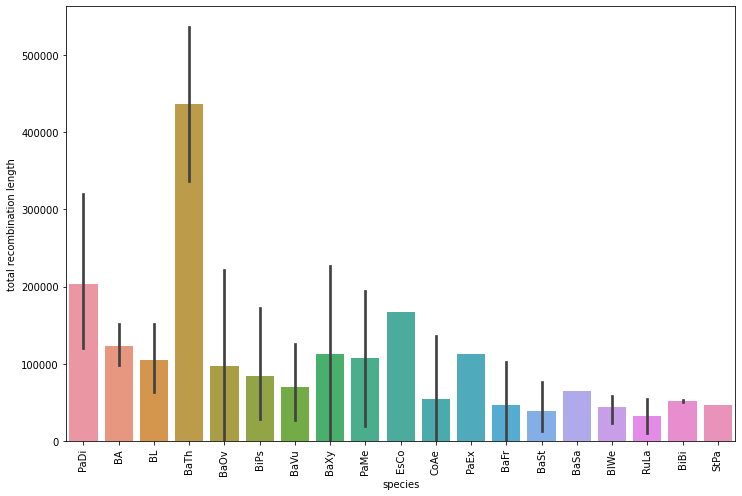

In [16]:
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(12, 8))
sns.barplot(data=all_recom_sum,x='species',y='total recombination length',ax=axs)
plt.xticks(rotation=90)
plt.savefig('../../donor_species/final_SNP/HSgene_new/recombination.pdf',bbox_inches='tight')


In [536]:
### convert tree to pdf
from Bio import Phylo
allfiles = glob.glob('../../donor_species/final_SNP/withcom/wired/*.tree')
for file in allfiles:
    try:
        tree = Phylo.read(file, "newick")
        lineage_name = os.path.basename(file).split('.fasta')[0]
        fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(8, 12))
        Phylo.draw(tree, axes=axs)
        plt.savefig('../../donor_species/final_SNP/withrecom/plot_removerec/tree/%s.pdf'%(lineage_name))
    except ValueError:
        pass

